# Expression of common vs other genes

This notebook asks if there is a technical reason for these commonly DEGs to be found as frequently differentially expressed. To answer this question, we will compare the average expression of common DEGs compared to other genes

In [1]:
%load_ext autoreload
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
project_id = params["project_id"]
col_to_rank_genes = params["rank_genes_by"]

In [3]:
# Read in non (0-1) normalized expression compendium
if dataset_name == "pseudomonas_analysis":
    raw_compendium_filename = params["raw_compendium_filename"]
    expression = pd.read_csv(raw_compendium_filename, sep="\t", index_col=0, header=0).T
else:
    mapped_compendium_filename = params["mapped_compendium_filename"]
    expression = pd.read_csv(
        mapped_compendium_filename, sep="\t", index_col=0, header=0
    )

In [4]:
expression.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DRR000897,4,24,0,158.0,19,0,1123,0,2875,2559,...,1418,3577,210,383,1302,312,865,10208,3792,1669
DRR001173,3,8,3,3.0,27,0,762,2,1403,2613,...,934,2904,165,520,834,5,2511,5859,3042,2182
DRR001174,2,3,3,7.0,41,2,321,2,1296,2467,...,1196,3316,210,702,825,4,3276,3464,3135,3143
DRR001175,1,3,1,3.0,16,2,38,0,1429,2964,...,619,604,301,854,945,4,1514,8481,3731,3163
DRR001176,0,0,2,1.0,8,3,40,0,1141,2539,...,475,494,290,801,1046,1,1549,6419,3420,2901


In [5]:
# Load gene_summary_filename
if dataset_name == "pseudomonas_analysis":
    gene_summary_filename = os.path.join(
        base_dir, dataset_name, f"generic_gene_summary_{project_id}_cbrB_v_WT.tsv"
    )
else:
    gene_summary_filename = os.path.join(
        base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
    )

summary_gene_ranks = pd.read_csv(gene_summary_filename, sep="\t", index_col=0, header=0)

In [6]:
summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950002e-13,17569.0,10.694069,10.694069,0.002644,15703.0,88.442041,0.545455,2.071917,1.709101,22,5.044847
PRAME,PRAME,2.959850e-15,17568.0,8.664896,8.664896,0.020151,13854.0,78.027487,0.545455,2.219810,2.247802,22,2.867283
SLCO1B3,SLCO1B3,5.291828e-04,17567.0,8.325529,8.325529,0.000205,16755.0,94.367466,0.727273,2.723600,1.671151,22,3.352139
KCNC2,KCNC2,1.983864e-10,17566.0,8.230783,8.230783,0.078105,15568.0,87.681649,0.409091,2.091518,1.844180,22,3.328995
HOTAIR,HOTAIR,3.115155e-10,17565.0,8.228355,8.228355,0.000887,17311.0,97.499155,0.600000,3.252611,2.453541,20,2.027985


## Get common and other genes

r = 0.1851597404594152
p = 3.711325673092676e-132
ci_low = 0.16976385397454688
ci_high = 0.1995459457315779


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


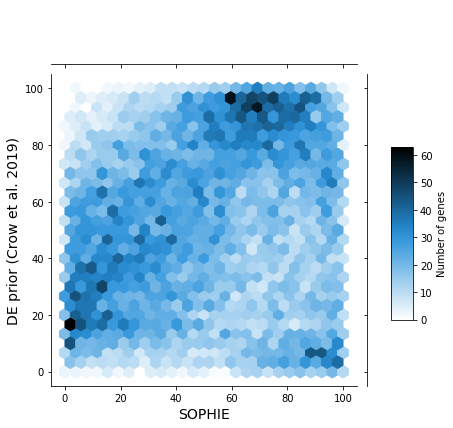

In [7]:
# Get generic genes identified by Crow et. al.
if dataset_name == "pseudomonas_analysis":
    DE_prior_filename = os.path.join(
        base_dir, dataset_name, params["reference_gene_filename"]
    )
else:
    DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_tmp.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename,
)

In [8]:
shared_ranking.head()

,Percentile (simulated),DE_Prior_Rank,Gene_Name
Gene_Order,,,
154,45.347527,99.201836,ADM
14469,0.822350,24.523971,POGK
14850,27.886673,22.536387,CDNF
9436,23.543990,50.779905,C12orf73
16281,73.329954,15.065992,ANKRD13B


In [9]:
# Get common gene ids
if dataset_name == "pseudomonas_analysis":
    common_ranking = shared_ranking[
        (shared_ranking["Percentile (simulated)"] > 80)
        & (shared_ranking["prop DEGs"] > 80)
    ]
    common_genes = common_ranking["gene id"]
else:
    common_ranking = shared_ranking[
        (shared_ranking["Percentile (simulated)"] > 80)
        & (shared_ranking["DE_Prior_Rank"] > 80)
    ]
    common_genes = common_ranking["Gene_Name"]


print(len(common_genes))

900


In [10]:
# Get other gene ids
if dataset_name == "pseudomonas_analysis":
    other_genes = set(shared_ranking["gene id"]).difference(common_genes)
else:
    other_genes = set(shared_ranking["Gene_Name"]).difference(common_genes)
print(len(other_genes))

16256


## Plot average expression

In [11]:
# Get average expression of genes
all_expression_mean = expression.mean()

In [12]:
# Format df for plotting
expression_mean_toplot = pd.DataFrame(
    data={
        "all genes": np.log10(all_expression_mean),
        "common genes": np.log10(all_expression_mean[common_genes]),
        "other genes": np.log10(all_expression_mean[other_genes]),
    }
)


expression_mean_toplot.head()

,all genes,common genes,other genes
A1BG,2.597952,NaN,2.597952
A1BG-AS1,2.321759,NaN,NaN
A1CF,2.287074,NaN,2.287074
A2M,3.754799,NaN,3.754799
A2M-AS1,2.248122,NaN,NaN


Text(0.5, 0, 'log10(average expression)')

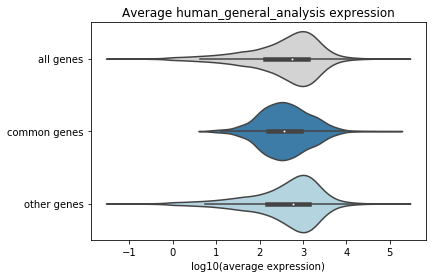

In [13]:
# Violin plot of average expression highlighing common vs other genes
f = sns.violinplot(
    data=expression_mean_toplot,
    palette=["lightgrey", "#2c7fb8", "#add8e6"],
    orient="h",
)
f.set_title(f"Average {dataset_name} expression")
f.set_xlabel("log10(average expression)")

In [14]:
f.get_figure().savefig(
    f"average_expression_common_vs_other_{dataset_name}.png",
    format="png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**

There doesn't appear to be a difference in expression between common genes vs other genes for this analysis. It would be interesting to continue to followup on this analysis to try to rule out other possible factors that could explain why these common DEGs are so common (for future work).